
[Github project link text](https://github.com/camygiuliani/giuliani-tesinaLabIA2023.git)

## Iniziamo

Questo è il mio progetto che ha come protagonista la Semantic Segmentation e la change detection.

##Che cosa vogliamo fare?
Si tratta di un problema di classificazione.Abbiamo a disposizione il dataset Sentinel2 con immagini satellitari , il nostro scopo sarà quello di classificare ogni pixel in base a 7 classi.

Importiamo le librerie e i moduli necessari.

In [5]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, SubsetRandomSampler, ConcatDataset
from torchvision import datasets, transforms
import os
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from google.colab import drive
from tqdm import tqdm
import time
!pip install albumentations
import albumentations as A
!pip install  segmentation_models_pytorch
import segmentation_models_pytorch as smp


!pip install rasterio
import rasterio
from rasterio.plot import show

torch.manual_seed(42) # Setting the seed
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
# Additionally, some operations on a GPU are implemented stochastic for efficiency
# We want to ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False
## colleghiamo con google dirve
from google.colab import drive
drive.mount('/content/drive')



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 39.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 80.2 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=9477c3a69db8296142c2a5e523a63bbf4575fa84ce4186a130384b3be73b4177
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=38723506352fa7c0b3dcf224e791dd1f62e7617391ec20ad6a792c072477f594
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c6

In [2]:
##Osserviamo una specifica immagine
file= rasterio.open("/content/drive/MyDrive/Lab_IA/sentinel2/1330_3107_13/2018_02.tif").read()
print("L'immagine ha dimensioni...",file.shape)


L'immagine ha dimensioni... (12, 1024, 1024)


In [8]:
## TUTTE LE COSTANTI QUA SOTTO
EPOCHS= 200
ROOT='/content/drive/MyDrive/Lab_IA'
CLASS_LABELS={ 0: "impervious serface",
               1: "agriculture",
               2: "forest & other vegetation",
               3: "wetlands",
               4: "soil",
               5: "water",
               6:"snow & ice"}
CHECKPOINT_DIR='/content/drive/MyDrive/Lab_IA/checkpoints'



Implementiamo la classe per il nostro dataset.

Come metriche utilizziamo

>IoU: The ratio between the intersection and the union of the predicted
segmentation and the ground truth.E'anche famosa come Jaccard Index,la usiamo per valutare l'accuratezza della sovrapposizione tra maschere predette e maschere di groud-truth


> mIoU: The mean of the IoU values across all the classes

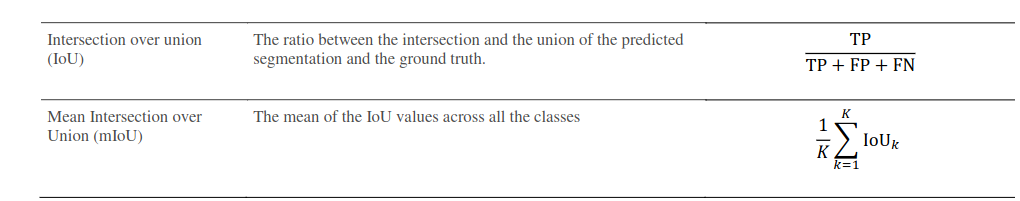







In [ ]:
## Funzioni per data augmentation
def get_train_augmentations(image,mask):
      '''
      '''
      transforms=[]
      transforms.extend([
          A.HorizontalFlip(p=0.5),
          A.VerticalFlip(p=0.5),
          A.RandomRotate90(p=1.0),
      ])

      return A.compose(transforms)

def get_test_augmentations(image,mask):
      transforms=[]

      '''
      '''

      return A.compose(transforms)



In [10]:
## funzioni per metriche

def get_intersection_union(pred,label,n_classi):
    #pred è un tensore(altezza,profondità)
    #convertiamo in np.array
    ## aggiungiamo +1 per ignorare i valori -1 corrispondenti alla classe snow and ice
    pred=np.asarray(pred)+1
    label= np.asarray(label)+1

    #elimino tutti gli elementi in pred corrispondenti alla classe 0
    pred= pred * (label>0)
    # calcolo intersezione
    intersezione= (pred==label)*pred
    inters_area= np.histogram(intersezione,bins=n_classi,range=(1,n_classi))
    pred_area= np.histogram(pred,bins=n_classi,range=(1,n_classi))
    label_area= np.histogram(label,bins=n_classi,range=(2,n_classi))

    ## per il calcolo dell'area di unione sommo le aree di pred e label e sottraggo l'intersezione
    unione_area= pred_area+label_area-inters_area
    return inters_area,unione_area

def get_IoU(intersezione,unione):
  iou= intersezione/unione
  return iou

def get_mIoU(iou_values):
  mean_iou= np.mean(iou_values)
  return mean_iou



In [7]:
class MyDynamicEarthNet(Dataset):
    def __init__(self, root, mode, mean=np.zeros((12,)),std=np.zeros((12,)),num_classes=7 ):
        """
        Args:
            root: the root of the folder which contains planet imagery and labels
            mode: train/val/test -- selects the splits

            reference_date: for positional encoding defaults:2018-01-01
            crop_size: crop size default:1024x1024
            num_classes: for DynamicEarthNet numclasses: 6

        """
        self.root = root
        self.mode = mode
        self.resize = crop_size

        self.num_classes = num_classes
        self.mean=mean
        self.std=std
        self.normalize = transforms.Normalize(mean=self.mean, std=self.std)

        self.files,self.labels= self.get_file_labels(mode)

        if(mode=="train"):
          self.augmentations= self.get_train_augmentations()
        else:
          self.augmentations= self.get_test_augmentations()

        self.calculate_mean_std()




    def get_file_labels(self,mode):

      with open(os.path.join(self.root,self.mode+".txt"),"r") as f:
        lista_file=[]
        for line in f:
          line=line.rstrip().split(' ')
          lista_file.append(line)
        self.files,self_labels=list(zip(*lista_file))

      self.mean,self.std= self.calculate_mean_std()

      return self.files, self_labels


    def set_files(self):
        self.file_list = os.path.join(self.root, "dynnet_training_splits", f"{self.mode}" + ".txt")
        print (self.file_list)
        file_list = [line.rstrip().split(' ') for line in tuple(open(self.file_list, "r"))]
        self.files, self.labels, self.year_months = list(zip(*file_list))

        if self.type == 'daily':
            self.all_days = list(range(len(self.files)))

            for i in range(len(self.files)):
                self.planet, self.day = [], []
                date_count = 0
                for _, _, infiles in os.walk(os.path.join(self.root, self.files[i][1:])):
                    for infile in sorted(infiles):
                        if infile.startswith(self.year_months[i]):
                            self.planet.append(os.path.join(self.files[i], infile))
                            self.day.append((datetime(int(str(infile.split('.')[0])[:4]), int(str(infile.split('.')[0][5:7])),
                                                  int(str(infile.split('.')[0])[8:])) - self.reference_date).days)
                            date_count += 1
                self.all_days[i] = list(zip(self.planet, self.day))
                self.all_days[i].insert(0, date_count)

        else:
            self.planet, self.day = [], []
            if self.type == 'weekly':
                self.dates = ['01', '05', '10', '15', '20', '25']
            elif self.type == 'single':
                self.dates = ['01']

            for i, year_month in enumerate(self.year_months):
                for date in self.dates:
                    curr_date = year_month + '-' + date
                    self.planet.append(os.path.join(self.files[i], curr_date + '.tif'))
                    self.day.append((datetime(int(str(curr_date)[:4]), int(str(curr_date[5:7])),
                                                  int(str(curr_date)[8:])) - self.reference_date).days)
            self.planet_day = list(zip(*[iter(self.planet)] * len(self.dates), *[iter(self.day)] * len(self.dates)))


    def load_data(self, index):
        cur_images, cur_dates = [], []
        if self.type == 'daily':
            for i in range(1, self.all_days[index][0]+1):
                img = rasterio.open(os.path.join(self.root, self.all_days[index][i][0][1:]))
                red = img.read(3)
                green = img.read(2)
                blue = img.read(1)
                nir = img.read(4)
                image = np.dstack((red, green, blue, nir))
                cur_images.append(np.expand_dims(np.asarray(image, dtype=np.float32), axis=0)) # np.array already\
                cur_dates.append(self.all_days[index][i][1])

            image_stack = np.concatenate(cur_images, axis=0)
            dates = torch.from_numpy(np.array(cur_dates, dtype=np.int32))
            label = rasterio.open(os.path.join(self.root, self.labels[index][1:]))
            label = label.read()
            mask = np.zeros((label.shape[1], label.shape[2]), dtype=np.int32)

            for i in range(self.num_classes + 1):
                if i == 6:
                    mask[label[i, :, :] == 255] = -1
                else:
                    mask[label[i, :, :] == 255] = i

            return (image_stack, dates), mask

        else:
            for i in range(len(self.dates)):
                # read .tif
                img = rasterio.open(os.path.join(self.root, self.planet_day[index][i][1:]))
                red = img.read(3)
                green = img.read(2)
                blue = img.read(1)
                nir = img.read(4)
                image = np.dstack((red, green, blue, nir))
                cur_images.append(np.expand_dims(np.asarray(image, dtype=np.float32), axis=0))   # np.array already\
            image_stack = np.concatenate(cur_images, axis=0)
            dates = torch.from_numpy(np.array(self.planet_day[index][len(self.dates):], dtype=np.int32))
            label = rasterio.open(os.path.join(self.root, self.labels[index][1:]))
            label = label.read()
            mask = np.zeros((label.shape[1], label.shape[2]), dtype=np.int32)

            for i in range(self.num_classes+1):
                if i == 6:
                    mask[label[i, :, :] == 255] = -1
                else:
                    mask[label[i, :, :] == 255] = i

            return (image_stack, dates), mask

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        ##immagine cercata
        imm= rasterio.open(os.path.join(self.root,self.files[index])).read()

        ##il formato giusto è float32
        imm=imm.astype(np.float32)

        ##carico anche l'etichetta
        label= rasterio.open(os.path.join(self.root,self.labels[index])).read()
        ##maschera per la classe
        mask=np.zeros((label.shape[1],label.shape[2]),dtype=np.int64)     ## label.shape[1] la larghezza e label.shape [2] per altezza
        for i in range(self.num_classi):
          ## non considero la classe 6 corrispondente a snow and ice
          if i==6:
            mask[label[i,:,:]==255]=-1
          else:
            mask[label[i,:,:]==255]=i

        ## è il momento di normalizzare e fare data augmentation
        imm_trasp=imm.transpose(1,2,0)
        augm= self.augmentations(image=imm_trasp,mask=mask)
        ##applico augmentation
        augm_img= augm["image"]
        ##transformo in tensore
        img= torch.from_numpy(augm_img.transpose(2,0,1))

        '''
        '''
        #normalizzo
        img=self.normalize(img)


        return img, mask



    def calculate_mean_std(self):
      # Mean
      print("Sto calcolando la media")
      sum= np.zeros((12,))
      num_pixel=0
      for im in tqdm(self.files):
        im_path= os.path.join(self.root,im)
        src= rasterio.open(im_path)
        img=src.read()
        sum += np.sum(img,axis={1,2})
        num_pixel+=img.shape[1]* img.shape[2]

      mean= sum/num_pixel

      ## Deviazione standard
      sum= np.zeros((12,))
      for im in tqdm(self.files):
        im_path= os.path.join(self.root,im)
        src= rasterio.open(im_path)
        img=src.read()
        sum += np.sum((img-mean.reshape(12,1,1))**2,axis={1,2})

      std= np.sqrt(sum/num_pixel)

      self.mean=mean
      self.std=std


NameError: ignored

In [ ]:
##creazione training, validation e test set
training

Parte sui DataLoader che non so assolutamente come fare :)

In [ ]:
# Crea il DataLoader utilizzando il dataset
dataloader = DataLoader(training, batch_size=??, shuffle=True, num_workers=yes)

#UNet
Implementiamo adesso la rete UNet che è una fully-convolutional-network

First path is the contraction path (also called as the encoder) which is used to capture the context in the image. The encoder is just a traditional stack of convolutional and max pooling layers. The second path is the symmetric expanding path (also called as the decoder) which is used to enable precise localization using transposed convolutions. Thus it is an end-to-end fully convolutional network (FCN), i.e. it only contains Convolutional layers and does not contain any Dense layer because of which it can accept image of any size.

In [6]:
n_channels=12
class UNet(nn.Module):
  def __init__(self):
    super(UNet,self).__init__()
    self.model = smp.Unet(in_channels=n_channels,classes=1,)
    self.model.encoder.conv1=nn.Conv2d(n_channels,out_channels=32,kernel_size=(3,3),stride=(1,1),padding=(1,1),bias=False)
    self.model.segmentation_head[0]=nn.Conv2d(16,6,kernel_size=(1,1),stride=(1,1))

  def forward(self,x):
    return self.model(x)

##testing my unet
model=UNet()
print(model)


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 94.2MB/s]


UNet(
  (model): Unet(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(12, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm

In [ ]:
import torch
import torchvision.models.segmentation as models
!pip install segmentation_models_pytorch
import segmentation_models_pytorch as smp

import segmentation_models_pytorch as smp

# Carica il modello U-Net predefinito
model = smp.Unet()

# Stampa l'architettura del modello
print(model)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 53.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.5/268.5 kB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 60.1 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=f2dc1e6663a58f49c05eb525fb6901ae84a0874cd62b0ac1fa9b0bd085cda568
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=13078ca9d6419a8b767bf1923c8403226f4994780465e61feb620eec074885cd
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c6

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 89.8MB/s]


Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [11]:
###Per checkpoint


# Loop di addestramento
for epoch in range(num_epochs):
    # Fai l'addestramento per l'epoca corrente
    ...

    # Salva il checkpoint dopo ogni epoca
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        # Aggiungi altre informazioni pertinenti al checkpoint
        ...
    }
    torch.save(checkpoint, f'checkpoint_epoch_{epoch}.pth')
